In [21]:
import json
import pprint
import os
import hashlib
from collections import defaultdict

In [22]:
def filter_json_by_allowlist(json_object, allowlist):
    filtered_json = {}
    for key, properties in json_object.items():
        filtered_properties = {
            prop: value for prop, value in properties.items() if prop in allowlist
        }
        filtered_json[key] = filtered_properties
    return filtered_json

In [23]:
# hash_to_meta = dict()
# hash_to_os = dict()
# hash_to_browser_release = dict()
host_to_browser_to_exp_to_fingerprint = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(str))))

In [24]:
hostnames = [
    "win10vm"
]

browsers = [
    # "chrome",
    # "edge",
    # "opera",
    # "brave",
    # "safari",
    "firefox",
    # "tor",
    # "ghostery",
]

In [25]:
directory = "./version_results"

for testsuite in os.listdir(directory):
    for filename in os.listdir(directory + "/" + testsuite):
        if not filename.endswith(".json"):
            continue

        FILE_A = filename
        DATA_A = None

        with open(f"{directory}/{testsuite}/{FILE_A}", "r") as json_file:
            DATA_A = json.load(json_file)

        meta = DATA_A["meta"]
        DATA = DATA_A["results"]
        if testsuite == "props":
            DATA = filter_json_by_allowlist(
                DATA,
                [
                    "font-size",
                    "font-family",
                    "inline-size",
                    "block-size",
                    "width",
                    "height",
                    "aspect-ratio",
                    "orientation",
                ],
            )

        if meta["host"] not in hostnames:
            continue
        if meta["browser"] not in browsers:
            continue

        hash = hashlib.md5(json.dumps(DATA).encode()).hexdigest()
        host_to_browser_to_exp_to_fingerprint[meta["host"]][meta["browser"]][
            meta["release"]
        ][meta["experiment"]] = hash

In [26]:
host_to_browser_to_exp_to_fingerprint = json.loads(json.dumps(host_to_browser_to_exp_to_fingerprint))

In [27]:
for host in host_to_browser_to_exp_to_fingerprint:
    for browser in browsers:
        if browser not in host_to_browser_to_exp_to_fingerprint[host]:
            host_to_browser_to_exp_to_fingerprint[host][browser] = dict()
# pprint.pprint(host_to_browser_to_exp_to_fingerprint)

In [28]:
host_to_browser_to_exp_to_fingerprint = host_to_browser_to_exp_to_fingerprint['win10vm']

labels = []
cm = []
for host_a in host_to_browser_to_exp_to_fingerprint:
    for browser_a in sorted(host_to_browser_to_exp_to_fingerprint[host_a]):
        line = []
        for host_b in host_to_browser_to_exp_to_fingerprint:
            for browser_b in sorted(host_to_browser_to_exp_to_fingerprint[host_b]):
                fp_a = host_to_browser_to_exp_to_fingerprint[host_a][browser_a]
                fp_b = host_to_browser_to_exp_to_fingerprint[host_b][browser_b]
                fp_a_serialized, fp_b_serialized = "", ""
                if "calc" in fp_a and "calc" in fp_b:
                    fp_a_serialized += fp_a["calc"]
                    fp_b_serialized += fp_b["calc"]
                # if "fontcontainer" in fp_a and "fontcontainer" in fp_b:
                #     fp_a_serialized += fp_a["fontcontainer"]
                #     fp_b_serialized += fp_b["fontcontainer"]
                # if "valuecontainer" in fp_a and "valuecontainer" in fp_b:
                #     fp_a_serialized += fp_a["valuecontainer"]
                #     fp_b_serialized += fp_b["valuecontainer"]
                # if "props" in fp_a and "props" in fp_b:
                #     fp_a_serialized += fp_a["props"]
                #     fp_b_serialized += fp_b["props"]
                if fp_a_serialized == "":
                    assert fp_a_serialized == fp_b_serialized
                    continue
                line.append(1 if fp_a_serialized != fp_b_serialized else 0)
        if sum(line) == 0:
            continue
        labels.append(f"{host_a} {browser_a}")
        cm.append(line)

In [29]:
pprint.pprint(host_to_browser_to_exp_to_fingerprint)
pprint.pprint(labels)

{'firefox': {'113': {'calc': '7027c5c5e0cd98ccf762512f55317ec4'},
             '114': {'calc': '2eaf4711e65d6185e713fbb8fb5c7fdc'},
             '115': {'calc': '2eaf4711e65d6185e713fbb8fb5c7fdc'},
             '116': {'calc': '2eaf4711e65d6185e713fbb8fb5c7fdc'},
             '117': {'calc': '513c29051e9d8f2a15a728520298ae89'},
             '118': {'calc': '513c29051e9d8f2a15a728520298ae89'},
             '119': {'calc': '513c29051e9d8f2a15a728520298ae89'},
             '120': {'calc': '513c29051e9d8f2a15a728520298ae89'},
             '121': {'calc': '513c29051e9d8f2a15a728520298ae89'},
             '122': {'calc': '5f17518f0ee796cc1bab68bbb86ac811'}}}
['firefox 113',
 'firefox 114',
 'firefox 115',
 'firefox 116',
 'firefox 117',
 'firefox 118',
 'firefox 119',
 'firefox 120',
 'firefox 121',
 'firefox 122']


/tmp/ipykernel_57516/1508274551.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((i + 0.01, i + 0.01), 0.98, 0.98, fill=True, color='lightgrey', edgecolor='lightgrey')


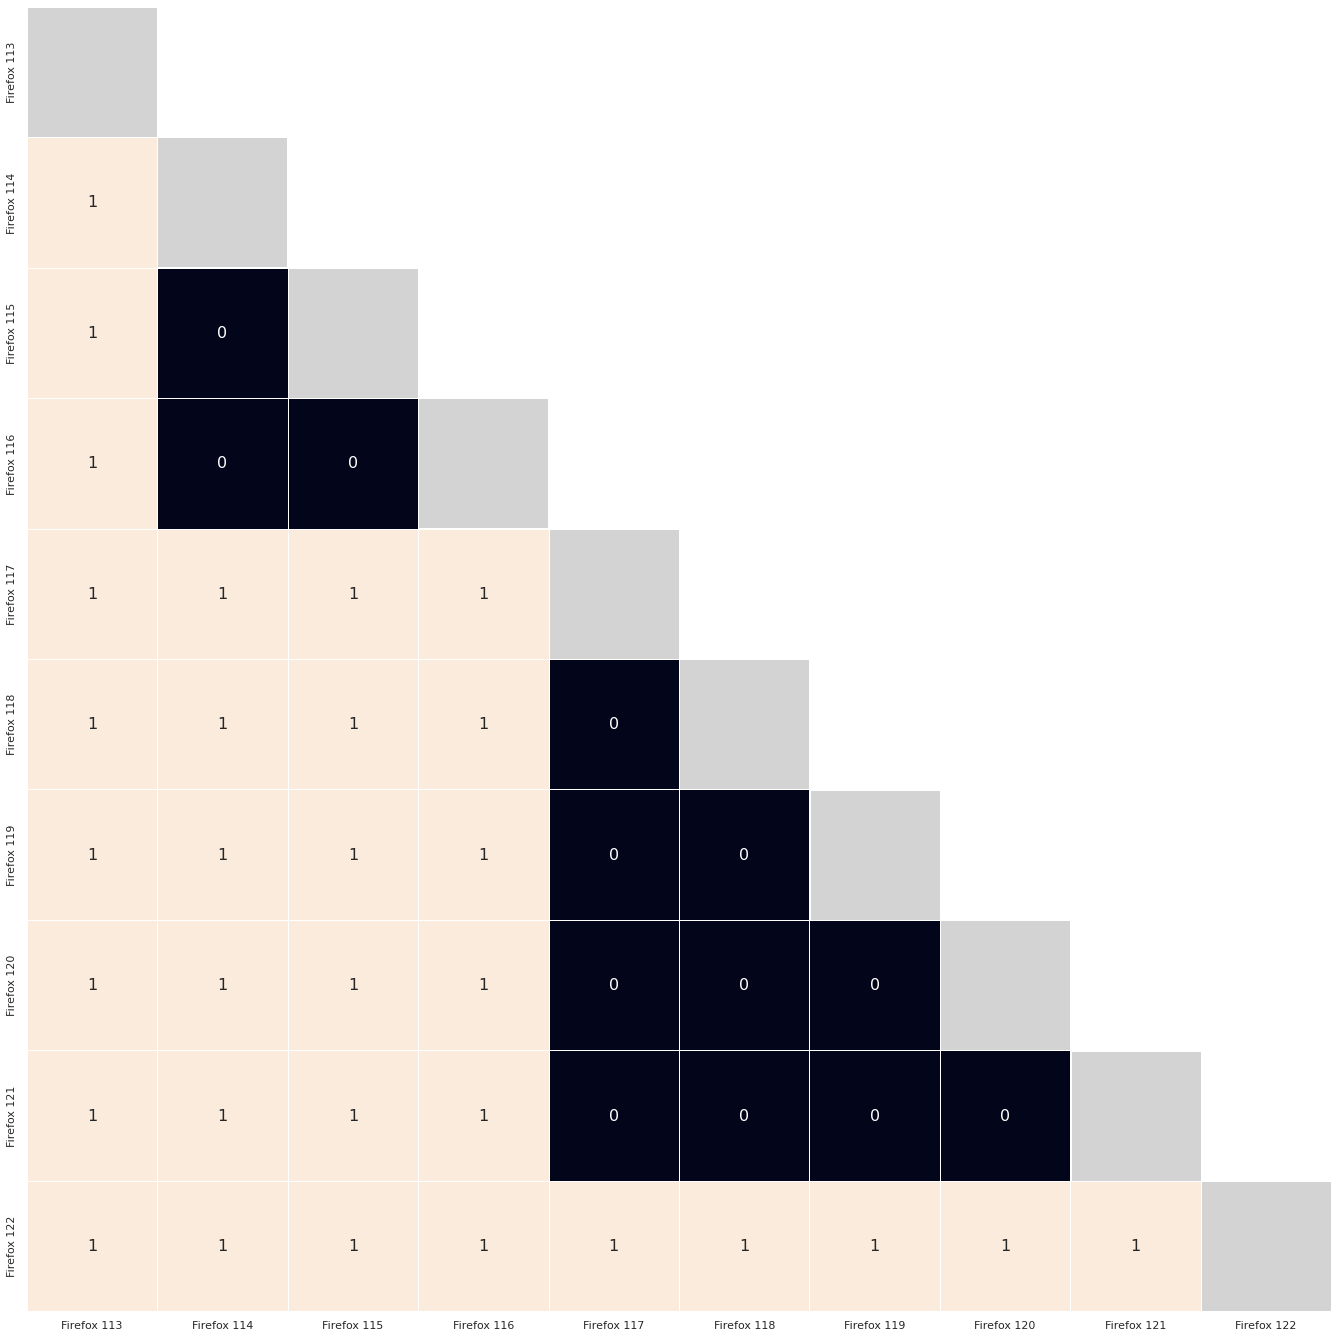

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

pretty_names = {
    "win10vm": "Windows 10",
    "win11vm": "Windows 11",
    "ubuntu22vm": "Ubuntu",
    "macbook": "macOS",
    "tablet": "ChromeOS",
    "pixel": "Android",
    "iphone13": "iOS",
    "chrome": "Google Chrome",
    "edge": "Microsoft Edge",
    "opera": "Opera",
    "brave": "Brave",
    "safari": "Safari",
    "firefox": "Firefox",
    "tor": "Tor",
    "ghostery": "Ghostery"
}
for old_name in pretty_names:
    labels = list(map(lambda x: x.replace(old_name, pretty_names[old_name]), labels))

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
mask = np.triu(np.ones_like(df_cm, dtype=bool))

plt.figure(figsize=(30,24))
sn.set(font_scale=1.4)
sn.set_theme(style='white')

cmap = ListedColormap(['white'] + sn.color_palette("coolwarm").as_hex())

ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cbar=False, square=True, linewidths=0.5, mask=mask)
# highlighted_ticks = [6]

# for tick in highlighted_ticks:
#     ax.axhline(y=tick, color='k', linewidth=2)
#     ax.axvline(x=tick, color='k', linewidth=2)

for i in range(len(df_cm)):
    rect = plt.Rectangle((i + 0.01, i + 0.01), 0.98, 0.98, fill=True, color='lightgrey', edgecolor='lightgrey')
    ax.add_patch(rect)

plt.show()